## Cognitive Battery Introduction: Jax-3DP3

In [1]:
# Code to visualize
# jax3dp3.setup_visualizer()
# jax3dp3.show_cloud("c1", object_cloud)
# jax3dp3.show_trimesh("mesh", learned_mesh)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax3dp3
from jax3dp3.viz import (
    save_depth_image,
    get_depth_image,
    multi_panel,
)
from jax3dp3.transforms_3d import transform_from_pos, depth_to_coords_in_camera
from jax3dp3.jax_rendering import (
    get_rectangular_prism_shape,
    render_planes_multiobject,
    batched_scorer_parallel_params,
)
import jax.numpy as jnp
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image
from sklearn.cluster import KMeans, OPTICS, DBSCAN
import trimesh
from tqdm import tqdm

import cog_utils as utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


1. Initialize camera metadata and path to data:

In [3]:
scene = "gravity"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [4]:
width = 300
height = 300
fov = 90

fx, fy, cx, cy = utils.get_camera_intrinsics(width, height, fov)

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])
near, far = 0.001, 50.0
K = jnp.array(
    [
        [fx_fy[0], 0.0, cx_cy[0]],
        [0.0, fx_fy[1], cx_cy[1]],
        [0.0, 0.0, 1.0],
    ]
)

jax3dp3.setup_renderer(height, width, fx, fy, cx, cy, near, far)

Increasing frame buffer size to (width, height, depth) = (320, 320, 2048)


2. Load ground-truth RGB images, depth, and segmentation data.


In [5]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    if not os.path.isfile(rgb_path):
        rgb_path = rgb_path.replace("jpeg", "png")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

3. Mask the depth and segmentation images to only include the relevant part of the scene (i.e. crop to the box above table).

In [6]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image, _ = depth_to_coords_in_camera(depth_images[frame_idx], K)
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.invert(
        # (coord_image[:, :, 0] < 2.0)
        # * (coord_image[:, :, 0] > -1)
        # * (coord_image[:, :, 1] < 0.463)
        # * (coord_image[:, :, 1] > -0.8)
        # * (coord_image[:, :, 2] < 3)
        # * (coord_image[:, :, 2] > 0.25)
        (coord_image[:, :, 0] < 1.1)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.565)
        * (coord_image[:, :, 1] > -1)
        * (coord_image[:, :, 2] > 1.2)
        * (coord_image[:, :, 2] < 1.35)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

In [7]:
# Load meshes
meshes = []
meshes_path = "/home/khaledshehada/cog_jax3dp3_data/gravity_data/meshes/"
for mesh_name in os.listdir(meshes_path):
    mesh_path = os.path.join(meshes_path, mesh_name)
    mesh = trimesh.load(mesh_path)
    jax3dp3.load_model(mesh)
    meshes.append(mesh_name.replace(".obj", ""))
    print(meshes[-1])

apple
tube_s_long
bowl
tube_s


4. Pick a starting frame and initialize the object shapes and poses from that frame

In [18]:
start_t = 36
seg_img = seg_images[start_t]
# Image.fromarray(seg_img)

Image.fromarray(seg_img).save("seg_img.png")

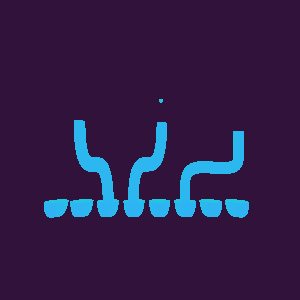

In [9]:
num_objects = 12
indices, init_poses = [], []
obj_ids = jnp.unique(seg_img.reshape(-1, 3), axis=0)
obj_ids = sorted(
    obj_ids, key=lambda x: jnp.all(seg_img == x, axis=-1).sum(), reverse=True
)
for obj_id in obj_ids[: num_objects + 1]:
    if jnp.all(obj_id == 0):
        # Background
        continue

    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    masked_depth = coord_images[start_t].copy()
    masked_depth[~obj_mask] = 0

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    obj_center = (maxs + mins) / 2
    obj_transform = transform_from_pos(obj_center)

    best = None
    k = np.inf
    for m in range(len(meshes)):
        obj_transforms = utils.get_object_transforms(meshes[m], obj_transform)
        for i, transform in enumerate(obj_transforms):
            rendered_image = jax3dp3.render_single_object(transform, m)
            keep_points = (
                jnp.sum(
                    jnp.logical_or(
                        (
                            (masked_depth[:, :, 2] != 0.0)
                            * (rendered_image[:, :, 2] == 0)
                        ),
                        (
                            (masked_depth[:, :, 2] == 0.0)
                            * (rendered_image[:, :, 2] != 0)
                        ),
                    )
                )
                / (rendered_image[:, :, 2] != 0.0).sum()
            )
            if keep_points < k:
                k = keep_points
                best = (m, transform)
    if best:
        indices.append(best[0])
        init_poses.append(best[1])

init_poses = jnp.array(init_poses)
rendered_image = jax3dp3.render_multiobject(init_poses, indices)
get_depth_image(rendered_image[:, :, 2], max=5)

6. Define the liklihood methods and the proposal enumerations.

In [10]:
# Liklihood parameters
r = radius = 0.1
outlier_prob = 0.01
outlier_volume = 10

# Enumeration parameters
n = 7  # number of enumerated proposals on each dimension (x, y, z).
d = 0.05  # the minimum and maximum position delta on each dimension (x, y, z).

# Enumerating proposals
translation_deltas = jax3dp3.make_translation_grid_enumeration(
    -d, -d, -d, d, d, d, n, n, n
)


def scorer(rendered_image, gt, prior):
    weight = jax3dp3.likelihood.threedp3_likelihood(
        gt, rendered_image, r, outlier_prob, outlier_volume
    )
    return prior * weight


scorer_parallel = jax.vmap(scorer, in_axes=(0, None, 0))
scorer_parallel_jit = jax.jit(scorer_parallel)

In [11]:
# Idea for liklihood model under occlusion:
# render object, check for k closest points in the point cloud, minimize the distance between current rendering and distance from closest points
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])

translation_deltas_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (translation_deltas.shape[0], pose_estimates.shape[0], 1, 1),
)
translation_deltas_full = translation_deltas_full.at[:, 0, :, :].set(translation_deltas)
translation_proposals = jnp.einsum(
    "bij,abjk->abik", pose_estimates, translation_deltas_full
)
images = jax3dp3.render_parallel(translation_proposals, 0)
# prior = 1 + translation_deltas[:,1,3] / n
prior = jnp.ones((translation_deltas.shape[0],))
weights_new = scorer_parallel_jit(images, gt_image, prior)
pose_estimates = translation_proposals[jnp.argmax(weights_new)]

In [12]:
num_steps = num_frames - start_t
num_steps = 150
inferred_poses = []
occlusion_threshold = 10
pose_estimates = init_poses.copy()
# tqdm = lambda x: x
# occluded = False
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])
    # New objects
    n_objects = pose_estimates.shape[0]
    for i in range(n_objects - 1, n_objects):
        # Check for occlusion
        depth_wi = jax3dp3.render_multiobject(pose_estimates, indices)
        depth_woi = jax3dp3.render_multiobject(pose_estimates[:i], indices[:i])
        if jnp.sum(depth_wi[:, :, 2] != depth_woi[:, :, 2]) < occlusion_threshold:
            # pose_estimate = pose_estimates[i]
            # translation_proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
            # pose_estimate = translation_proposals[best_weight_idx]
            # pose_estimates = pose_estimates.at[i].set(pose_estimate)
            # prior = (1 - translation_deltas[:,1,3]) * abs(translation_deltas[:,0,3]) * abs(translation_deltas[:,2,3])
            prior = (1 - translation_deltas[:, 1, 3]) * abs(translation_deltas[:, 2, 3])
            # occluded = True
            # prior = jnp.mean(jnp.array([
            #     1 - jnp.minimum(translation_deltas[:,1,3], 0),
            # 1 - jnp.abs(translation_deltas[:,0,3]),
            # 1 - jnp.abs(translation_deltas[:,2,3]),
            # ]), axis=0)
            # prior = jnp.ones((translation_deltas.shape[0],))

            # occluding_object = None
            # for j in range(n_objects):
            #     if i == j: continue
            #     delt = -1 if i > j else 0
            #     pose_estimates_without_j = jnp.concatenate((pose_estimates[:j], pose_estimates[j+1:]))
            #     indices_without_j = indices[:j] + indices[j+1:]
            #     depth_woj_wi = jax3dp3.render_multiobject(pose_estimates_without_j, indices_without_j)
            #     depth_woj_woi = jax3dp3.render_multiobject(pose_estimates_without_j[:i+delt], indices_without_j[:i+delt])
            #     if (jnp.sum(depth_woj_wi[:, :, 2] != depth_woj_woi[:, :, 2]) > occlusion_threshold):
            #         occluding_object = j
            #         break
        else:
            prior = jnp.ones((translation_deltas.shape[0],))

        pose_estimate = pose_estimates[i]
        translation_proposals = jnp.einsum(
            "ij,ajk->aik", pose_estimate, translation_deltas
        )
        images = jax3dp3.render_parallel(translation_proposals, indices[i])
        weights_new = scorer_parallel_jit(images, gt_image, prior)
        best_weight_idx = jnp.argmax(weights_new)
        pose_estimate = translation_proposals[best_weight_idx]
        pose_estimates = pose_estimates.at[i].set(pose_estimate)

    inferred_poses.append(pose_estimates.copy())

100%|██████████| 150/150 [00:29<00:00,  5.07it/s]


In [13]:
apple_pos = pose_estimates[-1, :-1, 3]
sorted_bowls = sorted(
    [
        pose_estimates[i, :-1, 3]
        for i in range(len(indices))
        if meshes[indices[i]] == "bowl"
    ],
    key=lambda x: x[0].item(),
)
closest_bowl_idx = jnp.argmin(
    jnp.array([abs(apple_pos[0] - bowl_pos[0]) for bowl_pos in sorted_bowls])
)

In [14]:
all_images = []
for t in tqdm(range(start_t, start_t + num_steps)):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    poses = inferred_poses[t - start_t]
    rendered_image = jax3dp3.render_multiobject(poses, indices)
    rendered_image = get_depth_image(rendered_image[:, :, 2], max=5)

    apple_pose = poses[-1]
    rendered_apple = jax3dp3.render_single_object(apple_pose, indices[-1])
    rendered_apple = get_depth_image(rendered_apple[:, :, 2], max=5)
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, rendered_image, rendered_apple],
            [
                f"Class: {closest_bowl_idx}\nRGB Image",
                f"   Frame: {t}\nActual Depth",
                "\nReconstructed Depth",
                "\nApple Only",
            ],
            # [f"RGB Image", f"Actual Depth", "Reconstructed Depth", "Reconstructed (Apple Only)"],
            middle_width=10,
            label_fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)

100%|██████████| 150/150 [00:12<00:00, 11.85it/s]


Saved output to: gravity_out.gif


7. For each frame, enumerate the positions of new object poses (currently translation only), and for each object pick the pose that maximizes the 3DP3 liklihood under a uniform prior.

In [15]:
# num_steps = num_frames - start_t
# num_steps = 2
# occlusion_threshold = 10
# inferred_poses = []
# pose_estimates = init_poses.copy()
# for t in tqdm(range(start_t, start_t + num_steps)):
#     gt_image = jnp.array(coord_images[t])

#     # New objects
#     n_objects = pose_estimates.shape[0]
#     for i in range(n_objects):
#         # Occlusion detection: render depth with and without each object. If no difference, don't move object.
#         depth_with_object = render_planes_multiobject_jit(pose_estimates)
#         idxs = jnp.arange(n_objects) != i
#         depth_without_object = render_planes_multiobject_multi_jit(
#             pose_estimates[idxs],
#             shape_planes[idxs],
#             shape_dims[idxs],
#         )

#         if (
#             jnp.sum(depth_with_object[:, :, 2] != depth_without_object[:, :, 2])
#             < occlusion_threshold
#         ):
#             continue

#         enumerations_full = jnp.tile(
#             jnp.eye(4)[None, :, :],
#             (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
#         )
#         enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
#         proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

#         weights = batched_scorer_parallel_jit(proposals, gt_image)
#         pose_estimates = proposals[weights.argmax()]
#     inferred_poses.append(pose_estimates.copy())

8. Get the reconstructed poses for each frame and save them as a gif file with the gt data

In [16]:
# all_images = []
# for t in range(start_t, start_t + num_steps):
#     rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
#     gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
#     depth = render_planes_multiobject_jit(inferred_poses[t - start_t])
#     depth = get_depth_image(depth[:, :, 2], max=5.0)
#     all_images.append(
#         multi_panel(
#             [rgb_viz, gt_depth_1, depth],
#             [f"\nRGB Image", f"   Frame: {t}\nActual Depth", "\nReconstructed Depth"],
#             middle_width=10,
#             label_fontsize=20,
#         )
#     )
# out_path = f"{scene}_out.gif"
# make_gif_from_pil_images(all_images, out_path)
# print("Saved output to:", out_path)